In [2]:
import os
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
NUM_CLASSES = 3
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

IMAGE_SIZE = (224, 224)
EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32

In [4]:
train_dir = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train'
test_dir = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test'
val_dir = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val'

In [5]:
def create_dataframe_from_directory(data_dir):
    filenames, labels = [], []
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name, 'images')
        list = [os.path.join(folder_name, 'images', filename)
                for filename in os.listdir(folder_path)]
        filenames.extend(list)
        labels.extend([folder_name] * len(list))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })


train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)

In [6]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df.index)
NUM_TEST_IMAGES = len(test_df.index)

STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_IMAGES / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE))
TEST_STEPS = int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE))

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))

Training images: 21715
COVID-19: 7658, Non-COVID: 7208, Normal: 6849

Validation images: 5417
COVID-19: 1903, Non-COVID: 1802, Normal: 1712

Test images: 6788
COVID-19: 2395, Non-COVID: 2253, Normal: 2140


In [7]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_set = data_aug.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 21715 validated image filenames belonging to 3 classes.


In [8]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_set = data_gen.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5417 validated image filenames belonging to 3 classes.


In [9]:
test_set = data_gen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6788 validated image filenames belonging to 3 classes.


In [10]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    # return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
    #                             CLASSES[correct_label] if not correct else ''), correct
    return "{} [{}]".format(CLASSES[label], CLASSES[correct_label] if not correct else '\u2713'), correct


def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch(batch, predictions=None):
    images, labels = batch

    labels = np.argmax(labels, axis=1)
    # print(labels)
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 12.0
    SPACING = 0.1

    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [11]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r',
               label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'],
               color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'],
               color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

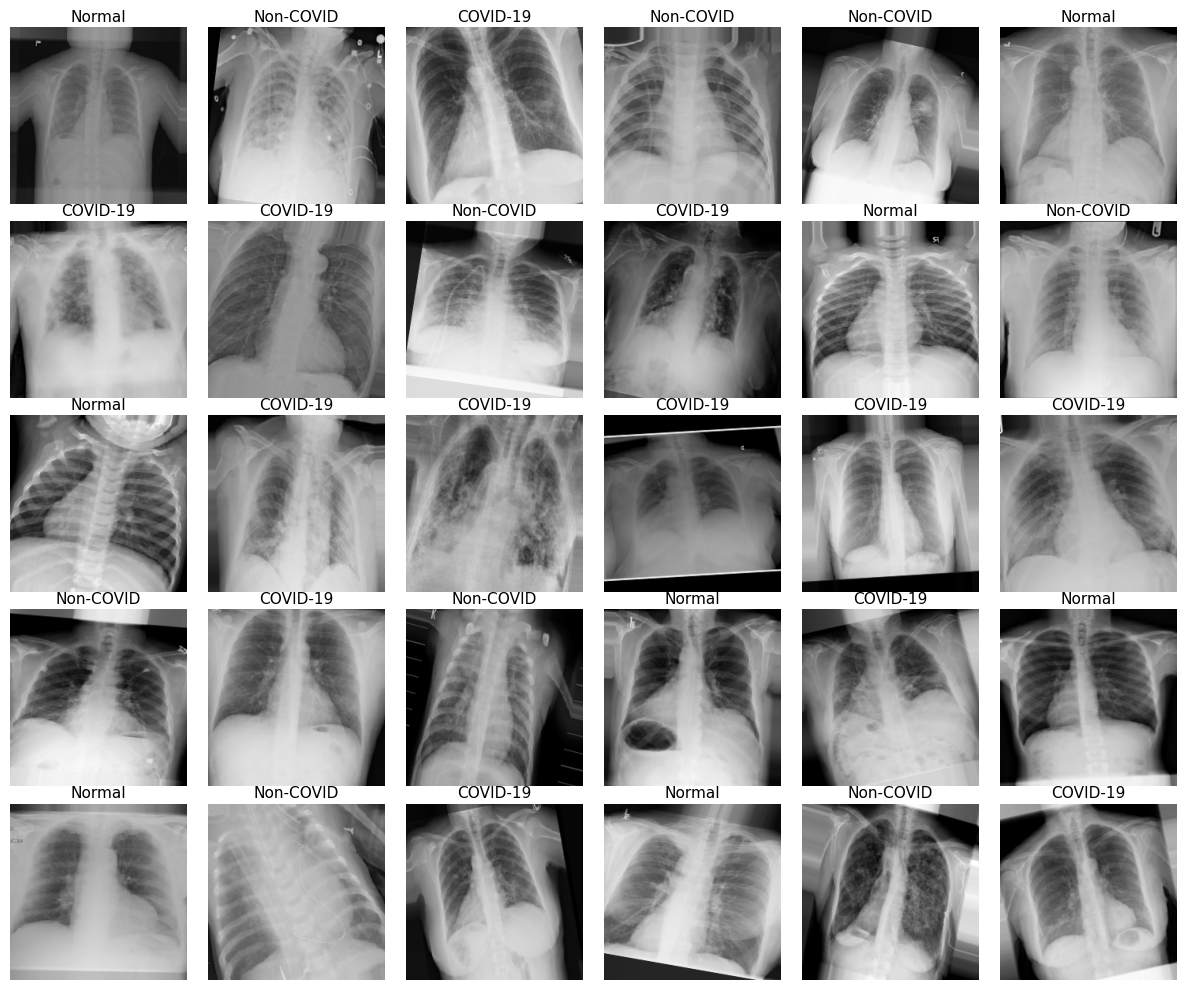

In [12]:
display_batch(next(iter(train_set)))

In [13]:
reduce_lr_val_acc = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-6,
)

reduce_lr_val_loss = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_xeception.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

In [15]:
baseModel = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 2s 0us/step


In [18]:
history = model.fit(
    train_set,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_set,
    validation_steps=VALIDATION_STEPS,
    epochs=25,
    callbacks=[reduce_lr_val_acc, reduce_lr_val_loss, checkpoint]
)

model.save('VGG16')

Epoch 1/25
679/679 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.5865
Epoch 1: val_loss improved from inf to 1.16582, saving model to best_xeception.h5
679/679 [==============================] - 396s 570ms/step - loss: 1.3768 - accuracy: 0.5865 - val_loss: 1.1658 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 2/25
679/679 [==============================] - ETA: 0s - loss: 1.1270 - accuracy: 0.6836
Epoch 2: val_loss did not improve from 1.16582
679/679 [==============================] - 297s 438ms/step - loss: 1.1270 - accuracy: 0.6836 - val_loss: 7.0688 - val_accuracy: 0.7425 - lr: 1.0000e-04
Epoch 3/25
679/679 [==============================] - ETA: 0s - loss: 2.2267 - accuracy: 0.7072
Epoch 3: val_loss did not improve from 1.16582
679/679 [==============================] - 299s 440ms/step - loss: 2.2267 - accuracy: 0.7072 - val_loss: 3.0716 - val_accuracy: 0.7399 - lr: 1.0000e-04
Epoch 4/25
679/679 [==============================] - ETA: 0s - loss: 1.4838 - a

<Figure size 640x480 with 0 Axes>

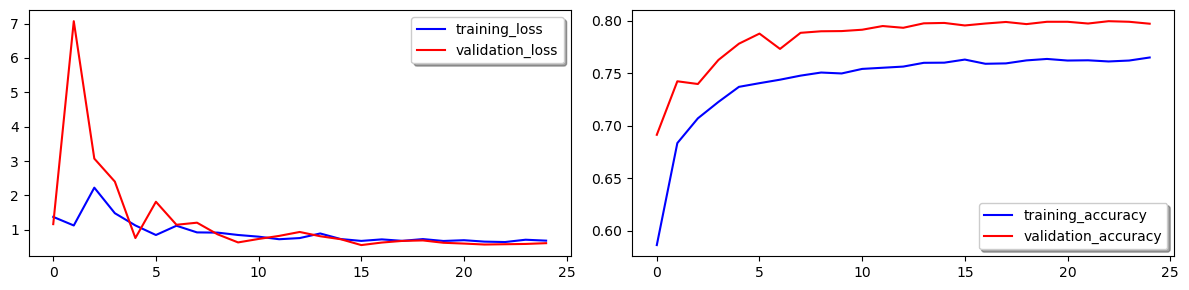

In [19]:
display_history(history)

In [20]:
results = model.evaluate(valid_set)

print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

170/170 [==============================] - 17s 100ms/step - loss: 0.5590 - accuracy: 0.7979
Test loss: 0.558984
Test accuracy: 0.797859


213/213 [==============================] - 56s 262ms/step
              precision    recall  f1-score   support

    COVID-19       0.85      0.79      0.82      2395
   Non-COVID       0.84      0.79      0.81      2253
      Normal       0.75      0.87      0.81      2140

    accuracy                           0.81      6788
   macro avg       0.82      0.81      0.81      6788
weighted avg       0.82      0.81      0.81      6788



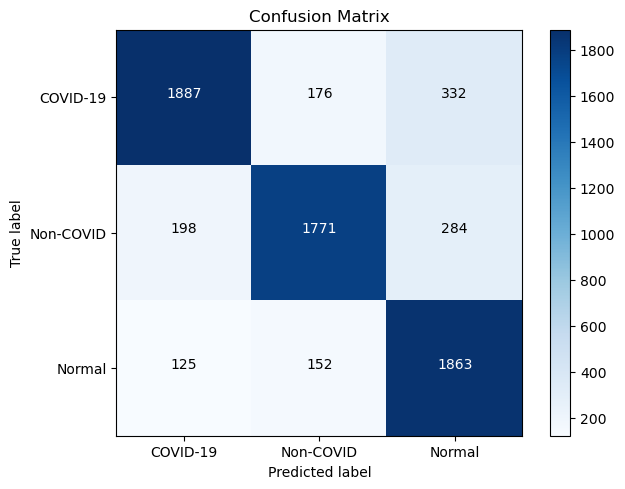

In [21]:
pred = model.predict(test_set, steps=TEST_STEPS)
y_pred = np.argmax(pred, axis=1)
y_true = test_set.classes

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')

In [22]:
batch = iter(test_set)

1/1 [==============================] - 0s 184ms/step


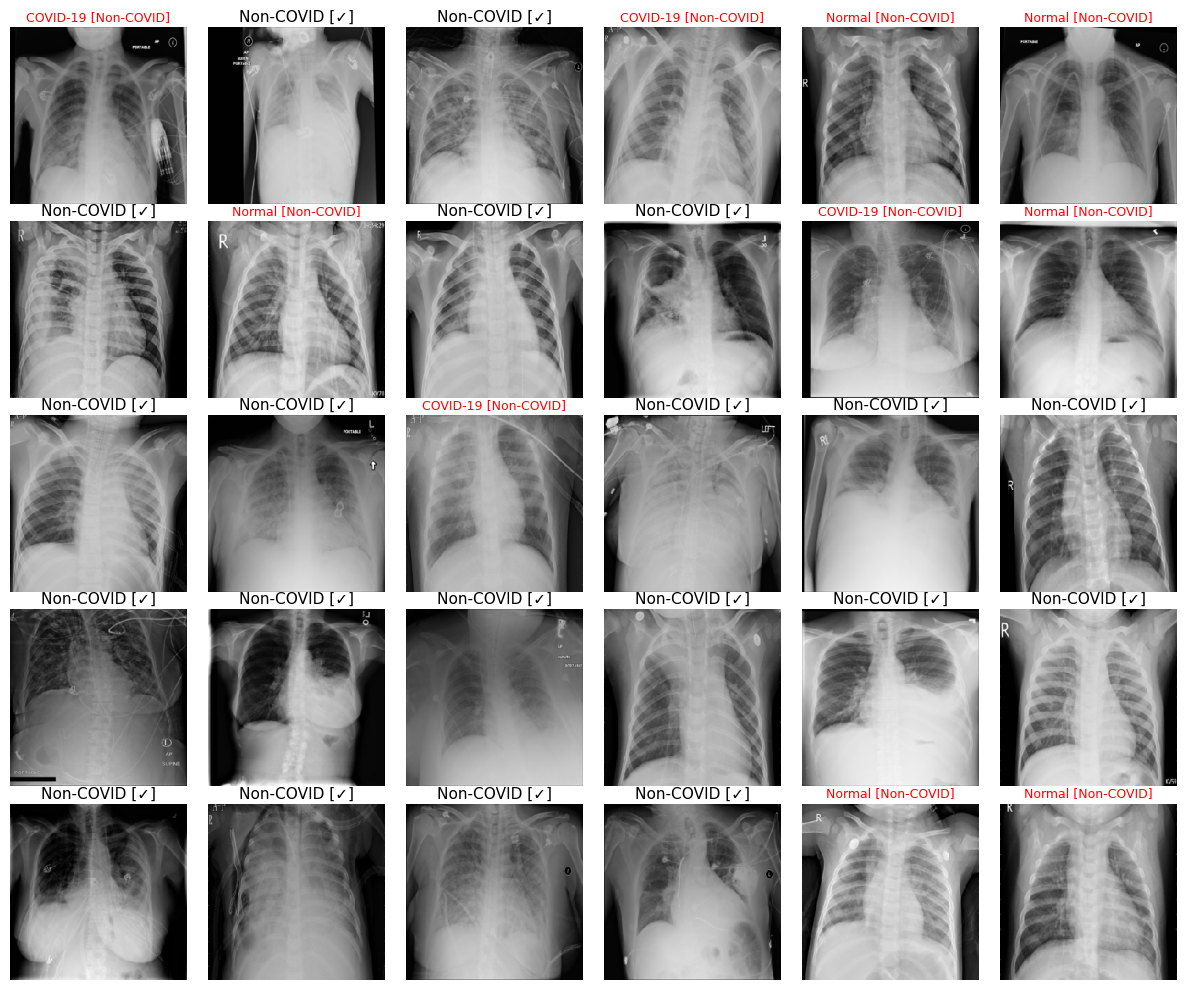

In [23]:
# run this cell again for next set of images
images, labels = next(batch)
predictions = np.argmax(model.predict(images), axis=-1)
display_batch((images, labels), predictions)